In [3]:
# Install necessary packages (uncomment the next line if running in a local environment without xgboost)


import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from itertools import combinations
import warnings

# Suppress warnings from libraries to clean output
warnings.filterwarnings("ignore")

# Load processed datasets
train_df = pd.read_csv('Processed_TrainSet.csv')
test_df = pd.read_csv('Processed_TestSet.csv')

# Convert numeric labels in the training set to string labels for consistency
label_mapping = {0: 'aggressive', 1: 'happy', 2: 'relaxed', 3: 'sad'}
train_df['class'] = train_df['class'].map(label_mapping)

# Separate features and target variables
y_train = train_df['class']
X_train = train_df.drop(columns=['class'])

y_test = test_df['class']
X_test = test_df.drop(columns=['class'])

# Ensure consistent label encoding using the same encoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# andatory features always included in the feature set
mandatory_features = ["SFm", "EDm", "RSm"]

# Additional top features based on ANOVA F-Test (excluding mandatory ones)
optional_features = ["SEm", "Em", "RGm", "Asm", "Rm", "RTm", "Km"]

# Generate fewer combinations: select up to 2 additional features from the optional ones
feature_combinations = [mandatory_features + list(combo) for combo in combinations(optional_features, 1)]
feature_combinations += [mandatory_features + list(combo) for combo in combinations(optional_features, 2)]

# Define models with tuned hyperparameters (removed use_label_encoder parameter from XGBoost)
models = {
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42),
    "SVM": SVC(C=10, kernel='rbf', random_state=42),
    "XGBoost": XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, eval_metric='mlogloss')
}

# Evaluate models with the generated feature combinations
results = []

for feature_set in feature_combinations:
    scaler = StandardScaler()
    X_train_sub = scaler.fit_transform(X_train[list(feature_set)])
    X_test_sub = scaler.transform(X_test[list(feature_set)])

    for name, model in models.items():
        model.fit(X_train_sub, y_train_encoded)
        predictions = model.predict(X_test_sub)

        accuracy = accuracy_score(y_test_encoded, predictions)
        results.append({
            "Model": name,
            "Features": feature_set,
            "Accuracy": accuracy
        })

# Create and display a DataFrame of results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Accuracy", ascending=False)

# Print the top 10 feature-model combinations with the highest accuracy
print("\n Top 10 Model-Feature Combinations by Accuracy:")
print(results_df.head(10))



 Top 10 Model-Feature Combinations by Accuracy:
                 Model                   Features  Accuracy
99             XGBoost   [SFm, EDm, RSm, Asm, Km]      0.80
103            XGBoost   [SFm, EDm, RSm, Rm, RTm]      0.75
50                 SVM   [SFm, EDm, RSm, SEm, Km]      0.75
47             XGBoost  [SFm, EDm, RSm, SEm, RTm]      0.75
29   Gradient Boosting   [SFm, EDm, RSm, SEm, Em]      0.75
15             XGBoost       [SFm, EDm, RSm, Asm]      0.75
43             XGBoost   [SFm, EDm, RSm, SEm, Rm]      0.75
49   Gradient Boosting   [SFm, EDm, RSm, SEm, Km]      0.75
51             XGBoost   [SFm, EDm, RSm, SEm, Km]      0.75
91             XGBoost   [SFm, EDm, RSm, Asm, Rm]      0.75


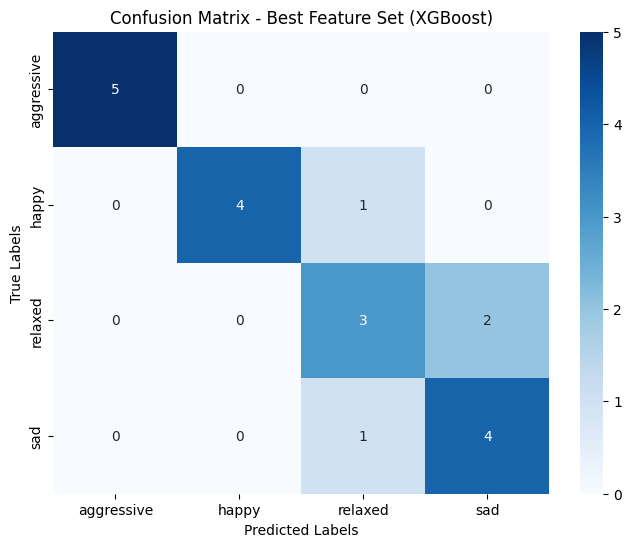

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the best feature set
best_features = ["SFm", "EDm", "RSm", "Asm", "Km"]

# Scale the data
scaler = StandardScaler()
X_train_best = scaler.fit_transform(X_train[best_features])
X_test_best = scaler.transform(X_test[best_features])

# Train the best model (XGBoost)
best_model = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, eval_metric='mlogloss')
best_model.fit(X_train_best, y_train_encoded)

# Predict on the test set
predictions = best_model.predict(X_test_best)

# Compute confusion matrix
cm = confusion_matrix(y_test_encoded, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Best Feature Set (XGBoost)')
plt.show()

In [5]:
# Compute classification report
report = classification_report(y_test_encoded, predictions, target_names=label_encoder.classes_, output_dict=True)

# Convert to DataFrame for better visualization
classification_report_df = pd.DataFrame(report).transpose()

# Print classification report
print(classification_report_df)


              precision  recall  f1-score  support
aggressive     1.000000     1.0  1.000000      5.0
happy          1.000000     0.8  0.888889      5.0
relaxed        0.600000     0.6  0.600000      5.0
sad            0.666667     0.8  0.727273      5.0
accuracy       0.800000     0.8  0.800000      0.8
macro avg      0.816667     0.8  0.804040     20.0
weighted avg   0.816667     0.8  0.804040     20.0
